## Inverse halftone autoencoder using skip connections between encoder and decoder 

In [1]:
import platform
print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print('Platform System: ' + platform.system())
print(platform.processor())
print(platform.python_compiler())

x86_64
Darwin Kernel Version 18.6.0: Thu Apr 25 23:16:27 PDT 2019; root:xnu-4903.261.4~2/RELEASE_X86_64
Darwin-18.6.0-x86_64-i386-64bit
uname_result(system='Darwin', node='Tommy-1520.local', release='18.6.0', version='Darwin Kernel Version 18.6.0: Thu Apr 25 23:16:27 PDT 2019; root:xnu-4903.261.4~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Platform System: Darwin
i386
GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)


In [2]:
import sys
import numpy
import matplotlib
import pandas
import keras

Using TensorFlow backend.


In [3]:
print('Python: {}'.format(sys.version))
print('numpy: {}'.format(numpy.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('pandas: {}'.format(pandas.__version__))
print('keras: {}'.format(keras.__version__))

Python: 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy: 1.15.4
matplotlib: 3.0.2
pandas: 0.23.4
keras: 2.2.4


In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard
import time
import pickle
import sys

start = time.time();

np.random.seed(42)

In [5]:
import numpy as np

IMG_SIZE = 64
image_size = 64

x_train_pickle = pickle.load(open("x_train.pickle","rb"))
x_test_pickle = pickle.load(open("x_test.pickle", "rb"))
x_train_halftone_pickle = pickle.load(open("x_train_halftone.pickle","rb"))
x_test_halftone_pickle = pickle.load(open("x_test_halftone.pickle", "rb"))

x_test = np.array(x_test_pickle).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
x_train = np.array(x_train_pickle).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
x_test_halftone = np.array(x_test_halftone_pickle).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
x_train_halftone = np.array(x_train_halftone_pickle).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train_halftone = x_train_halftone.astype('float32') / 255.0
x_test_halftone = x_test_halftone.astype('float32') / 255.0

print(x_train[150].squeeze().max())
print(x_train_halftone[150].squeeze().max())
print(x_test[150].squeeze().max())
print(x_test_halftone[150].squeeze().max())

0.96862745
1.0
1.0
1.0


In [6]:
print(x_train.shape)
print(x_train_halftone.shape)

print(x_test.shape)
print(x_test_halftone.shape)

(10972, 64, 64, 3)
(10972, 64, 64, 3)
(1495, 64, 64, 3)
(1495, 64, 64, 3)


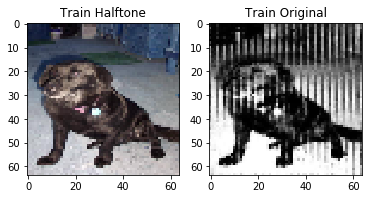

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Train Halftone')
ax1.imshow(x_train[0,:,:,:])

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Train Original')
ax2.imshow(x_train_halftone[0,:,:,:])

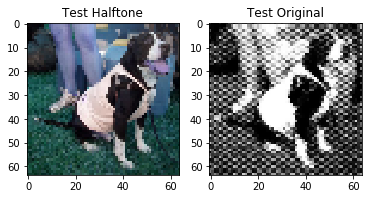

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Test Halftone')
ax1.imshow(x_test[0,:,:,:])

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Test Original')
ax2.imshow(x_test_halftone[0,:,:,:])

In [9]:
print(x_test.shape)
print(x_test_halftone.shape)

(1495, 64, 64, 3)
(1495, 64, 64, 3)


In [10]:
x_test2 = x_test[...,::-1,:] #flip horiz
x_test3 = x_test[:,::-1,...] #flip vert
x_test4 = x_test3[...,::-1,:] #flip both
x_test = np.append(x_test,x_test2)
x_test = np.append(x_test,x_test3)
x_test = np.append(x_test,x_test4)

x_train2 = x_train[...,::-1,:] #flip horiz
x_train3 = x_train[:,::-1,...] #flip vert
x_train4 = x_train3[...,::-1,:] #flip both
x_train = np.append(x_train,x_train2)
x_train = np.append(x_train,x_train3)
x_train = np.append(x_train,x_train4)

x_train_halftone2 = x_train_halftone[...,::-1,:] #flip horiz
x_train_halftone3 = x_train_halftone[:,::-1,...] #flip vert
x_train_halftone4 = x_train_halftone3[...,::-1,:] #flip both
x_train_halftone = np.append(x_train_halftone,x_train_halftone2)
x_train_halftone = np.append(x_train_halftone,x_train_halftone3)
x_train_halftone = np.append(x_train_halftone,x_train_halftone4)

x_test_halftone2 = x_test_halftone[...,::-1,:] #flip horiz
x_test_halftone3 = x_test_halftone[:,::-1,...] #flip vert
x_test_halftone4 = x_test_halftone3[...,::-1,:] #flip both
x_test_halftone = np.append(x_test_halftone,x_test_halftone2)
x_test_halftone = np.append(x_test_halftone,x_test_halftone3)
x_test_halftone = np.append(x_test_halftone,x_test_halftone4)

In [11]:
print(x_test2.shape)
print(x_test3.shape)
print(x_test4.shape)
print(x_test.shape)

print(x_train2.shape)
print(x_train3.shape)
print(x_train4.shape)
print(x_train.shape)

print(x_test_halftone2.shape)
print(x_test_halftone3.shape)
print(x_test_halftone4.shape)
print(x_test_halftone.shape)

print(x_train_halftone2.shape)
print(x_train_halftone3.shape)
print(x_train_halftone4.shape)
print(x_train_halftone.shape)

(1495, 64, 64, 3)
(1495, 64, 64, 3)
(1495, 64, 64, 3)
(73482240,)
(10972, 64, 64, 3)
(10972, 64, 64, 3)
(10972, 64, 64, 3)
(539295744,)
(1495, 64, 64, 3)
(1495, 64, 64, 3)
(1495, 64, 64, 3)
(73482240,)
(10972, 64, 64, 3)
(10972, 64, 64, 3)
(10972, 64, 64, 3)
(539295744,)


In [12]:
x_test = np.array(x_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
x_train = np.array(x_train).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
x_test_halftone = np.array(x_test_halftone).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
x_train_halftone = np.array(x_train_halftone).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(x_test.shape)
print(x_train.shape)
print(x_test_halftone.shape)
print(x_train_halftone.shape)

(5980, 64, 64, 3)
(43888, 64, 64, 3)
(5980, 64, 64, 3)
(43888, 64, 64, 3)


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


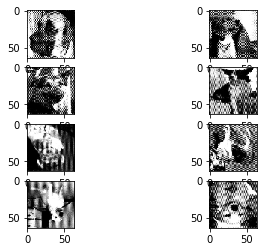

In [13]:
plt.subplot(4,2,1)
plt.imshow(x_train[750].squeeze(),cmap="gray")
plt.subplot(4,2,2)
plt.imshow(x_train[751].squeeze(),cmap="gray")
plt.subplot(4,2,3)
plt.imshow(x_train[750+10997].squeeze(),cmap="gray")
plt.subplot(4,2,4)
plt.imshow(x_train[750+10998].squeeze(),cmap="gray")
plt.subplot(4,2,5)
plt.imshow(x_train[750+10997*2].squeeze(),cmap="gray")
plt.subplot(4,2,6)
plt.imshow(x_train[750+10998*2-1].squeeze(),cmap="gray")
plt.subplot(4,2,7)
plt.imshow(x_train[750+10997*3].squeeze(),cmap="gray")
plt.subplot(4,2,8)
plt.imshow(x_train[750+10998*3-2].squeeze(),cmap="gray")

plt.subplot(4,2,1)
plt.imshow(x_train_halftone[750].squeeze(),cmap="gray")
plt.subplot(4,2,2)
plt.imshow(x_train_halftone[751].squeeze(),cmap="gray")
plt.subplot(4,2,3)
plt.imshow(x_train_halftone[750+10997].squeeze(),cmap="gray")
plt.subplot(4,2,4)
plt.imshow(x_train_halftone[750+10998].squeeze(),cmap="gray")
plt.subplot(4,2,5)
plt.imshow(x_train_halftone[750+10997*2].squeeze(),cmap="gray")
plt.subplot(4,2,6)
plt.imshow(x_train_halftone[750+10998*2-1].squeeze(),cmap="gray")
plt.subplot(4,2,7)
plt.imshow(x_train_halftone[750+10997*3].squeeze(),cmap="gray")
plt.subplot(4,2,8)
plt.imshow(x_train_halftone[750+10998*3-2].squeeze(),cmap="gray")

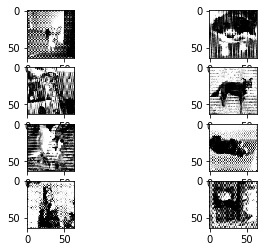

In [14]:
plt.subplot(4,2,1)
plt.imshow(x_test[750].squeeze(),cmap="gray")
plt.subplot(4,2,2)
plt.imshow(x_test[751].squeeze(),cmap="gray")
plt.subplot(4,2,3)
plt.imshow(x_test[750+1499].squeeze(),cmap="gray")
plt.subplot(4,2,4)
plt.imshow(x_test[750+1500].squeeze(),cmap="gray")
plt.subplot(4,2,5)
plt.imshow(x_test[750+1499*2].squeeze(),cmap="gray")
plt.subplot(4,2,6)
plt.imshow(x_test[750+1500*2-1].squeeze(),cmap="gray")
plt.subplot(4,2,7)
plt.imshow(x_test[750+1499*3].squeeze(),cmap="gray")
plt.subplot(4,2,8)
plt.imshow(x_test[750+1500*3-2].squeeze(),cmap="gray")

plt.subplot(4,2,1)
plt.imshow(x_test_halftone[750].squeeze(),cmap="gray")
plt.subplot(4,2,2)
plt.imshow(x_test_halftone[751].squeeze(),cmap="gray")
plt.subplot(4,2,3)
plt.imshow(x_test_halftone[750+1499].squeeze(),cmap="gray")
plt.subplot(4,2,4)
plt.imshow(x_test_halftone[750+1500].squeeze(),cmap="gray")
plt.subplot(4,2,5)
plt.imshow(x_test_halftone[750+1499*2].squeeze(),cmap="gray")
plt.subplot(4,2,6)
plt.imshow(x_test_halftone[750+1500*2-1].squeeze(),cmap="gray")
plt.subplot(4,2,7)
plt.imshow(x_test_halftone[750+1499*3].squeeze(),cmap="gray")
plt.subplot(4,2,8)
plt.imshow(x_test_halftone[750+1500*3-2].squeeze(),cmap="gray")

In [15]:
input_shape = (image_size, image_size, 3)
num_epochs = 2
batch_size = 128
kernel_size = 3
latent_dim = 32

from keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization

input_img = Input(shape=(image_size, image_size, 3),
                  name = 'input')

x = Conv2D(filters = 16,
           kernel_size = (3, 3),
           strides = (1, 1),
           
           padding='same',
           name = 'conv0')(input_img)
x = BatchNormalization()(x)
x  = Activation('tanh')(x)
res0 = x

x = Conv2D(filters = 16,
           kernel_size = (3, 3),
           strides = (1, 1),
           
           padding='same',
           name = 'conv1')(x)
x = BatchNormalization()(x)
x  = Activation('tanh')(x)
res1 = x


x = MaxPooling2D(pool_size = (2, 2),
                 padding='same',
                 name = "pool1")(x)


x = Conv2D(filters = 16,
           kernel_size = (3, 3),
           strides = (1, 1),
           
           padding='same',
          name = 'conv4')(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
res4 = x

encoded = MaxPooling2D(pool_size = (2, 2),
                       padding='same',
                      name = 'pool2')(x)

x = Conv2D(8, (3, 3), 
           padding='same')(encoded)


x = UpSampling2D(size = (2, 2))(x)

x = Conv2DTranspose(filters = 16, 
                    kernel_size = (3, 3), 
                    strides = (1,1),
                     
                    padding='same',
                   name = "conv_transpose1")(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([res4,x])
x = Activation('tanh')(x)


x = UpSampling2D(size = (2, 2))(x)

x = Conv2DTranspose(filters = 16, 
                    kernel_size = (3, 3), 
                    strides = (1,1),
                    
                    padding='same',
                   name = "conv_transpose2")(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([res1,x])
x = Activation('tanh')(x)

x = Conv2DTranspose(filters = 16, 
                    kernel_size = (3, 3), 
                    strides = (1,1),
                    
                    padding='same',
                   name = "conv_transpose3")(x)
x = BatchNormalization()(x)
x = keras.layers.Add()([res0,x])
x = Activation('tanh')(x)

decoded = Conv2DTranspose(filters = 3,
                          kernel_size = (3, 3),
                          strides = (1, 1),
                          activation='sigmoid',
                          padding='same',
                         name = "output_conv_transpose")(x)

autoencoder = Model(input_img, decoded)

autoencoder.summary()

autoencoder.compile(metrics = ['mse'],
                    loss='mse', 
                    optimizer='adadelta')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 64, 16)   448         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 16)   64          conv0[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv1 (Con

In [16]:
start = time.time();

#Image reconstruction model fit
autoencoder.fit(x_train_halftone,
                x_train,
                validation_data= (x_test_halftone, x_test),
                epochs=num_epochs,
                batch_size=batch_size)

end = time.time();

Train on 43888 samples, validate on 5980 samples
Epoch 1/2
43888/43888 [==============================] - 857s 20ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 2/2
43888/43888 [==============================] - 839s 19ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0239 - val_mean_squared_error: 0.0239


In [17]:
x_decoded = autoencoder.predict(x_test_halftone)

In [18]:
print(start)
print(end)
print(end - start)

1559079093.808974
1559080790.714549
1696.9055750370026


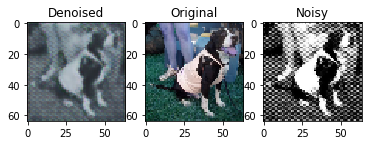

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Denoised')
ax1.imshow(x_decoded[0].squeeze())

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Original')
ax2.imshow(x_test[0].squeeze())

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Noisy')
ax3.imshow(x_test_halftone[0].squeeze())

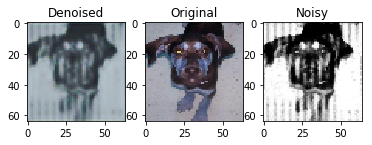

In [22]:
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Denoised')
ax1.imshow(x_decoded[75].squeeze())

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Original')
ax2.imshow(x_test[75].squeeze())

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Noisy')
ax3.imshow(x_test_halftone[75].squeeze())

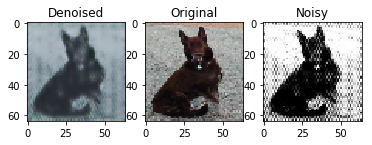

In [23]:
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Denoised')
ax1.imshow(x_decoded[30].squeeze())

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Original')
ax2.imshow(x_test[30].squeeze())

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Noisy')
ax3.imshow(x_test_halftone[30].squeeze())

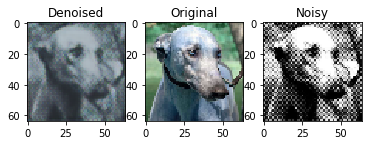

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Denoised')
ax1.imshow(x_decoded[210].squeeze())

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Original')
ax2.imshow(x_test[210].squeeze())

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Noisy')
ax3.imshow(x_test_halftone[210].squeeze())

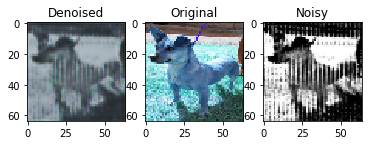

In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Denoised')
ax1.imshow(x_decoded[560].squeeze())

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Original')
ax2.imshow(x_test[560].squeeze())

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Noisy')
ax3.imshow(x_test_halftone[560].squeeze())

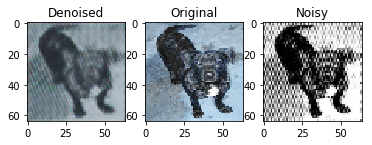

In [30]:
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Denoised')
ax1.imshow(x_decoded[4].squeeze())

ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Original')
ax2.imshow(x_test[4].squeeze())

ax3 = fig.add_subplot(1,3,3)
ax3.set_title('Noisy')
ax3.imshow(x_test_halftone[4].squeeze())

In [ ]:
autoencoder.save('autoencoder.h5')
autoencoder.save_weights('autoencoder_weights.h5')